# 环境及数据准备

## 安装依赖

In [1]:
import pandas as pd
import string
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

## 数据读入

In [2]:
sms_raw = pd.read_csv("/home/xavier/Downloads/SmsSpam/sms_spam.csv")
sms_raw.head(5)

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
sms_raw.describe()

,type,text
count,5567,5567
unique,2,5054
top,ham,"Sorry, I'll call later"
freq,4822,30


In [4]:
sms_raw.dtypes

type    object
text    object
dtype: object

# 数据预处理

## 特征编码

In [5]:
sms_raw['type'] = pd.Series(sms_raw['type'].factorize()).iloc[0]
#查看编码后的特征分布。
sms_raw.groupby('type').count()

,text
type,
0,4822
1,745


## 无效数据清洗

In [6]:
# 将所有字母转换为小写
def tolower(text):
    return text.lower()
# 去除标点符号和数字
def removePunctuation(text):
    return text.translate({None: string.punctuation+('1234567890')})
# 进行变换
sms_raw['text'] = sms_raw['text'].map(removePunctuation).map(tolower)
#去除停用词
count_vect = CountVectorizer(stop_words="english",decode_error='ignore')
sms_counts = count_vect.fit_transform(sms_raw['text'])

In [7]:
sms_counts.shape

(5567, 5388)

In [8]:
#使用TF-IDF进行特征提取以降低词频矩阵维度
tfidf_vect = TfidfVectorizer(stop_words="english",decode_error='ignore',min_df=5)
sms_tfidf = tfidf_vect.fit_transform(sms_raw['text'])

In [9]:
sms_tfidf.shape

(5567, 912)

## 数据集划分

In [10]:
train_x, test_x, train_y, test_y = train_test_split(sms_tfidf, sms_raw['type'], test_size=0.3)

In [11]:
train_y.value_counts()/len(train_y)

0    0.866016
1    0.133984
Name: type, dtype: float64

In [12]:
test_y.value_counts()/len(test_y)

0    0.866547
1    0.133453
Name: type, dtype: float64

## 可视化

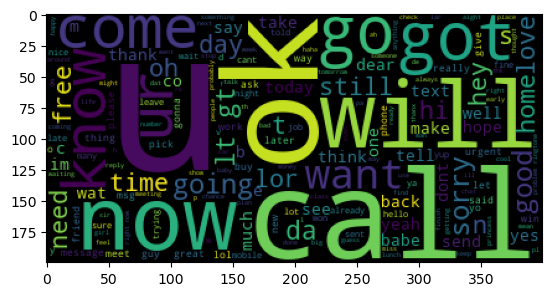

In [13]:
#查看全部信息的词云
wc = WordCloud()
wc.generate(''.join(sms_raw['text']))
plt.imshow(wc)

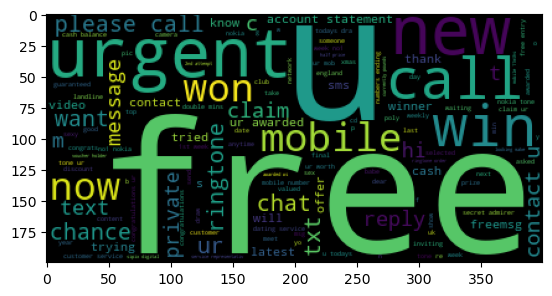

In [14]:
#查看垃圾短信的词云
wc.generate(''.join(sms_raw['text'][sms_raw['type']==1]))
plt.imshow(wc)

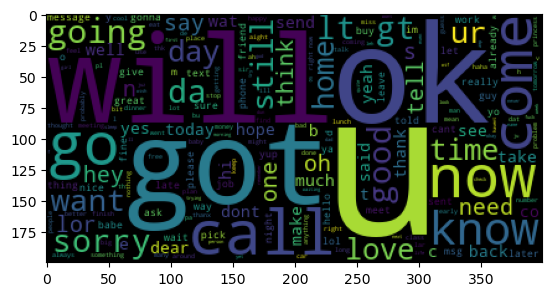

In [15]:
#查看非垃圾短信的词云
wc.generate(''.join(sms_raw['text'][sms_raw['type']==0]))
plt.imshow(wc)

# 构建和训练模型

In [16]:
sms_classifier = MultinomialNB().fit(train_x,train_y)

# 模型性能评估

In [17]:
# 对测试集的样本进行预测
test_pred = sms_classifier.predict(test_x)

In [18]:
#与真实值比较，查看模型对正样本和负样本的预测情况
metrics.confusion_matrix(test_y, test_pred)

array([[1436,   12],
       [  72,  151]])

In [19]:
#其他性能参数
print(metrics.classification_report(test_y, test_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      1448
           1       0.93      0.68      0.78       223

    accuracy                           0.95      1671
   macro avg       0.94      0.83      0.88      1671
weighted avg       0.95      0.95      0.95      1671

